The purpose of this project is to perform Image Classification on Deep Neural Network using a Flower Dataset from Kaggle.


The model should be able to detect different vegetable species namely:
1. Daisies
2. Dandelions
3. Roses
4. Sunflowers
5. Tulips

In [91]:
#Importing my libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, RandomFlip, RandomRotation, RandomZoom, RandomTranslation
from tensorflow.keras.optimizers import Adam

In [92]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Loading and Pre-processing the data

This process involves the following:
1. Load image data into a Data Pipeline
2. Normalize the image data
3. Split the data into training and validation datasets

In [93]:
#Setting a path directory for my image data and other variables
data_dir = "data/flowers"
imgsize = 256

#Loading the data into a Data Pipeline
data = tf.keras.utils.image_dataset_from_directory(data_dir, label_mode="categorical", image_size=(imgsize,imgsize))

#Normalizing the data
norm_data = data.map(lambda x,y: (x/255, y))
norm_iterator = norm_data.as_numpy_iterator()
batch = norm_iterator.next()

Found 4317 files belonging to 5 classes.


In [94]:
#Defining the size of our training, validation and test
train_size = int(len(norm_data) * 0.7)
val_size =  test_size = int(len(norm_data) * 0.15)

#Creating my train, validation and testing datasets using the sizes set above
train_ds = norm_data.take(train_size)
val_ds = norm_data.skip(train_size).take(val_size)
test_ds = norm_data.skip(train_size + val_size).take(test_size)


Building the Model

In this step I will be:
1. Defining the Model Structure

In this section I am defining the Model Structure. I use an iterative process of varying the layer properties to get an optimal solution

2. Training the Model
3. Plotting the Accuracy and Loss of the Model


In [95]:
#https://www.tensorflow.org/tutorials/images/data_augmentation

#Adding Data Augmentation in order to overcome overfitting the model
data_augmentation = keras.Sequential(
  [
    RandomFlip("horizontal",
                      input_shape=(imgsize,
                                  imgsize,
                                  3)),
    RandomRotation(0.1),
    RandomZoom(0.1),
    RandomTranslation(0.2, 0.2)             
  ]
)

#Initializing my Model Structure
model = keras.Sequential()

#Defining my Model Structure

#Data Augmentation Layer
model.add(data_augmentation)

#Adding Filters and Max Pooling Layers
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 
model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#Flattening the Layer
model.add(Flatten())

#Drop Out Layer with a 20% probability
model.add(Dropout(0.2)) 

#Dense Layers
model.add(Dense(512, activation = "relu"))
model.add(Dense(5, activation = "softmax"))


#Compiling the model with Adam optimizer, categorical cross-entropy loss function, and accuracy as its metric
model.compile(optimizer = Adam(learning_rate=0.001), loss = "categorical_crossentropy", metrics = ["accuracy"])

#Visual Representation of the Model
model.summary()


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_17 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 conv2d_40 (Conv2D)          (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 64, 64, 96)      

In [96]:
#Training the Model
history = model.fit(train_ds,validation_data=val_ds, batch_size = 32, epochs = 20)

Epoch 1/20
94/94 [==============================] - 37s 362ms/step - loss: 1.3658 - accuracy: 0.4019 - val_loss: 1.1270 - val_accuracy: 0.5547
Epoch 2/20
94/94 [==============================] - 34s 362ms/step - loss: 1.1594 - accuracy: 0.5206 - val_loss: 1.1193 - val_accuracy: 0.5344
Epoch 3/20
94/94 [==============================] - 34s 362ms/step - loss: 1.0466 - accuracy: 0.5831 - val_loss: 0.9604 - val_accuracy: 0.6266
Epoch 4/20
94/94 [==============================] - 33s 346ms/step - loss: 0.9626 - accuracy: 0.6130 - val_loss: 0.9779 - val_accuracy: 0.6422
Epoch 5/20
94/94 [==============================] - 34s 356ms/step - loss: 0.9558 - accuracy: 0.6263 - val_loss: 0.9849 - val_accuracy: 0.6078
Epoch 6/20
94/94 [==============================] - 35s 367ms/step - loss: 0.9184 - accuracy: 0.6430 - val_loss: 0.9395 - val_accuracy: 0.6375
Epoch 7/20
94/94 [==============================] - 34s 364ms/step - loss: 0.8812 - accuracy: 0.6679 - val_loss: 0.8775 - val_accuracy: 0.6578

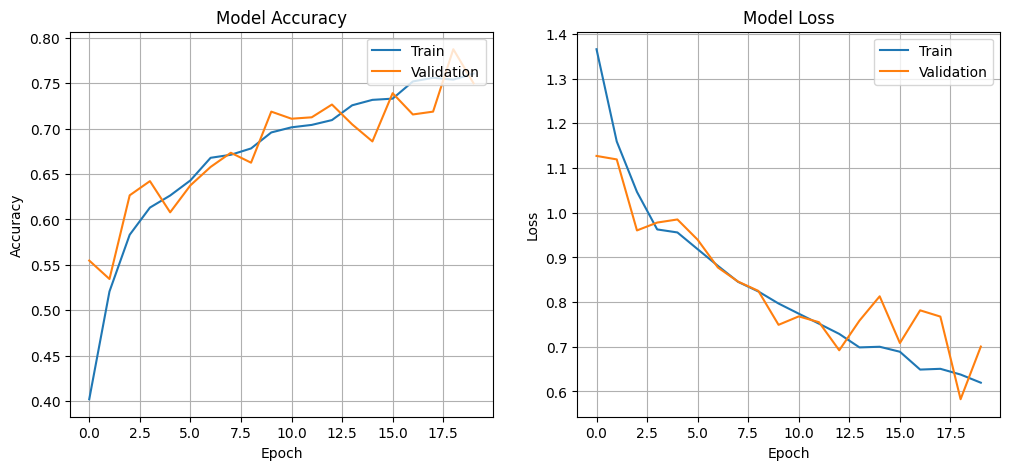

In [97]:
fig, (accuracy,loss) = plt.subplots(1,2, figsize =(12, 5))

#Plotting my accuracy values
accuracy.plot(history.history["accuracy"])
accuracy.plot(history.history["val_accuracy"])
accuracy.set_title("Model Accuracy")
accuracy.set_ylabel("Accuracy")
accuracy.set_xlabel("Epoch")
accuracy.legend(["Train","Validation"], loc = "upper right")
accuracy.grid()

#Plotting my accuracy values
loss.plot(history.history["loss"])
loss.plot(history.history["val_loss"])
loss.set_title("Model Loss")
loss.set_ylabel("Loss")
loss.set_xlabel("Epoch")
loss.legend(["Train","Validation"], loc = "upper right")
loss.grid()


Evaluating the Performance

In this sections we will be:
1. Calculating the accuracy and loss of the model using the test values
2. Obtaining predictions and performing some data analysis ie confusion matrix etc
3. test the model using outsourced data that isn't in the dataset

In [98]:
#Obtaing the accuracy and loss results of the model
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

20/20 [==============================] - 2s 32ms/step - loss: 0.7267 - accuracy: 0.7203
Test Loss: 0.7266684770584106
Test Accuracy: 0.7203124761581421


20/20 [==============================] - 3s 33ms/step
Confusion Matrix:
[[28 21 27 17 20]
 [31 32 41 22 28]
 [21 31 23 17 21]
 [26 31 29 20 15]
 [40 35 23 25 16]]


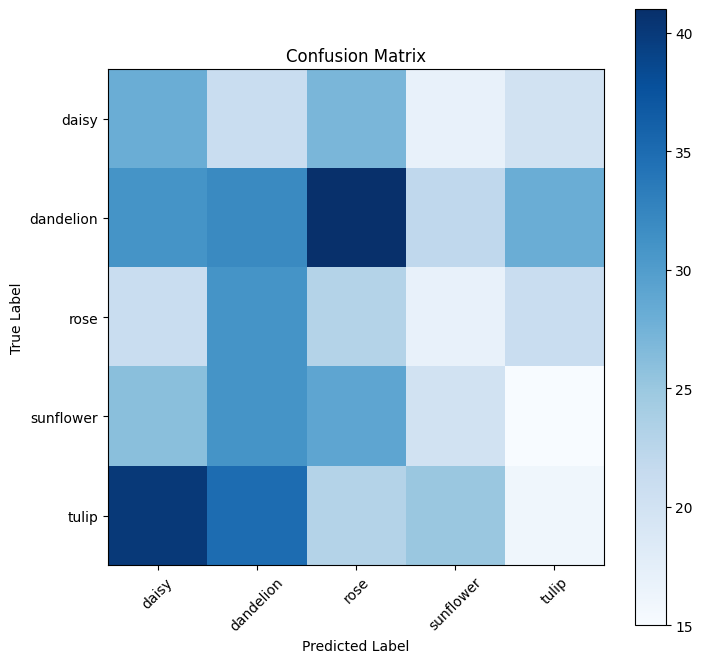

In [101]:
# Generate predictions on the test set
predictions = model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)

# Convert true labels to array
true_labels = np.concatenate([y for x, y in test_ds], axis=0)
true_labels = np.argmax(true_labels, axis=1)

# Compute and display confusion matrix
confusion_matrix = tf.math.confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(confusion_matrix.numpy())

# Plotting the confusion matrix
class_names = sorted(os.listdir(data_dir))
plt.figure(figsize=(8, 8))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

1/1 [==============================] - 0s 14ms/step


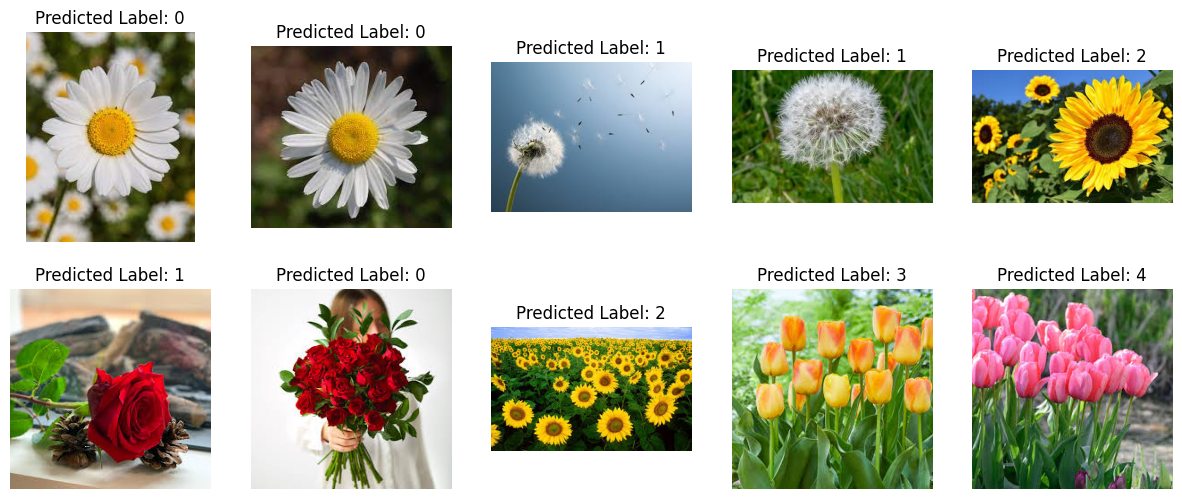

In [100]:
# Setting a path directory for my outsourced image data
predict_dir = "data/test_images"

# Function to make predictions and plot the image
def predict_and_plot(model, image_path, subplot_index):
    # Read and resize the image
    img = cv2.imread(image_path)
    img_resize = tf.image.resize(img, (imgsize, imgsize))

    # Normalize the image
    img_normalized = img_resize / 255.0

    # Make a prediction
    pred = model.predict(np.expand_dims(img_normalized, 0))
    predicted_label = np.argmax(pred[0])

    # Plot the image and predictions in a subplot
    plt.subplot(2, 5, subplot_index + 1)  # Assuming 10 images for the subplot (2 rows, 5 columns)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f'Predicted Label: {predicted_label}')
    plt.axis('off')  # Turn off axis for better visualization

# Set up the subplot grid
plt.figure(figsize=(15, 6))  # Adjust the figsize based on your preference

# Loop through images in the predict_dir and make predictions
for subplot_index, image in enumerate(os.listdir(predict_dir)):
    img_path = os.path.join(predict_dir, image)
    predict_and_plot(model, img_path, subplot_index)

# Show the entire subplot
plt.show()